In [60]:
import numpy as np

In [61]:
# Load wine dataset
data_path = 'wine/wine.data'
data = np.loadtxt(data_path, delimiter=',')

# First column is class label, rest are features
y = data[:, 0].astype(int)  # Class labels (1, 2, 3)
X = data[:, 1:]  # Features (13 features)

# Convert labels to 0-indexed (0, 1, 2 instead of 1, 2, 3)
y = y - 1

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (178, 13)
Number of classes: 3
Class distribution: [59 71 48]


In [62]:
# Split into train/val/test with stratification
from sklearn.model_selection import train_test_split

# First split: train (70%) and temp (30% for val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Second split: val (15%) and test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"  Class distribution: {np.bincount(y_train)}")
print(f"Val set: {X_val.shape[0]} samples")
print(f"  Class distribution: {np.bincount(y_val)}")
print(f"Test set: {X_test.shape[0]} samples")
print(f"  Class distribution: {np.bincount(y_test)}")



Train set: 124 samples
  Class distribution: [41 50 33]
Val set: 27 samples
  Class distribution: [ 9 10  8]
Test set: 27 samples
  Class distribution: [ 9 11  7]


In [63]:
# Optional: Normalize features (recommended for neural networks)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features normalized using StandardScaler")
print(f"Train mean: {X_train_scaled.mean(axis=0)[:3]}... (first 3 features)")
print(f"Train std: {X_train_scaled.std(axis=0)[:3]}... (first 3 features)")

# Use scaled versions for training
X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled



Features normalized using StandardScaler
Train mean: [3.08982230e-15 3.23218155e-16 2.34579381e-15]... (first 3 features)
Train std: [1. 1. 1.]... (first 3 features)


In [64]:
class Linear:
    def __init__(self, input_dim, output_dim):
        # Xavier/Glorot initialization for better training
        self.weights = np.random.uniform(-1, 1, (output_dim, input_dim))
        self.biases = np.zeros((output_dim,))

        self.input = None  # Store input for backward pass
        
        self.num_params = output_dim * input_dim + output_dim

    def forward(self, X):
        self.input = X  # Store input for backward pass
        return X @ self.weights.T + self.biases
        
    def backward(self, grad_output, lr):
        """
        grad_output: gradient from next layer, shape (batch_size, output_dim)
        Returns: gradient w.r.t. input, shape (batch_size, input_dim)
        """
        self.lr = lr
        m = self.input.shape[0]
        # Gradient w.r.t. weights: dL/dW = (grad_output^T @ input) / m
        d_weights = grad_output.T @ self.input / m
        # Gradient w.r.t. biases: dL/db = mean(grad_output, axis=0)
        d_biases = np.mean(grad_output, axis=0)
        # Update weights and biases
        self.weights -= self.lr * d_weights
        self.biases -= self.lr * d_biases
        # Gradient w.r.t. input: dL/dX = grad_output @ weights
        grad_input = grad_output @ self.weights
        return grad_input

linear = Linear(13, 100)
print(X_train.shape)
output = linear.forward(X_train)
print(f"Output shape: {output.shape}")
output

(124, 13)
Output shape: (124, 100)


array([[ 2.07509048, -0.25991758,  2.79253552, ...,  0.927539  ,
        -2.03296585, -2.92732432],
       [ 3.44074206,  0.23602744,  0.21939756, ...,  3.37271289,
         0.1503128 , -2.99635033],
       [ 0.81317743,  1.20567369, -0.38167794, ...,  0.96421423,
        -0.62403274, -2.18039303],
       ...,
       [-1.43850026,  2.24282269, -3.89086025, ...,  0.15986409,
        -0.06733135,  0.61383125],
       [-1.21330938, -0.09193873, -0.44072807, ..., -1.22935115,
         1.36709105,  1.3846795 ],
       [-3.50524446, -1.01053287,  1.17528805, ..., -5.68350575,
        -0.12203895,  4.00664182]])

In [65]:
class ReLU:
    def __init__(self):
        self.input = None  # Store input for backward pass
    
    def forward(self, X):
        self.input = X  # Store input for backward pass
        return np.maximum(0, X)
    
    def backward(self, grad_output):
        """
        grad_output: gradient from next layer
        Returns: gradient w.r.t. input
        """
        # Gradient is 1 where input > 0, else 0
        grad_input = grad_output * (self.input > 0).astype(float)
        return grad_input
    
relu = ReLU()
output = relu.forward(output)
print(f"Output shape: {output.shape}")
print(output)

Output shape: (124, 100)
[[2.07509048 0.         2.79253552 ... 0.927539   0.         0.        ]
 [3.44074206 0.23602744 0.21939756 ... 3.37271289 0.1503128  0.        ]
 [0.81317743 1.20567369 0.         ... 0.96421423 0.         0.        ]
 ...
 [0.         2.24282269 0.         ... 0.15986409 0.         0.61383125]
 [0.         0.         0.         ... 0.         1.36709105 1.3846795 ]
 [0.         0.         1.17528805 ... 0.         0.         4.00664182]]


In [66]:
class Softmax:
    def forward(self, X):
        exp_scores = np.exp(X - np.max(X, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    def backward(self, X, y, y_pred):
        m = X.shape[0]
        d_scores = y_pred
        d_scores[np.arange(m), y] -= 1
        d_scores /= m
        return d_scores
    
softmax = Softmax()
output = softmax.forward(output)
print(f"Output shape: {output.shape}")

Output shape: (124, 100)


In [67]:
class NeuralNetwork:
    def __init__(self, input_dim, output_dim):
        self.linear1 = Linear(input_dim, 100)
        print(f"Linear1 parameters: {self.linear1.num_params}")
        self.relu1 = ReLU()
        self.linear2 = Linear(100, 200)
        print(f"Linear2 parameters: {self.linear2.num_params}")
        self.relu2 = ReLU()
        self.linear3 = Linear(200, 100)
        print(f"Linear3 parameters: {self.linear3.num_params}")
        self.relu3 = ReLU()
        self.linear4 = Linear(100, output_dim)
        print(f"Linear4 parameters: {self.linear4.num_params}")
        self.softmax = Softmax()
        print(f"total parameters: {self.linear1.num_params + self.linear2.num_params + self.linear3.num_params + self.linear4.num_params}")
        
    
    def forward(self, X):
        out = self.linear1.forward(X)
        out = self.relu1.forward(out)
        out = self.linear2.forward(out)
        out = self.relu2.forward(out)
        out = self.linear3.forward(out)
        out = self.relu3.forward(out)
        out = self.linear4.forward(out)
        out = self.softmax.forward(out)
        return out
    
    def backward(self, y_true, y_pred, lr):
        """
        Backward pass through the network
        y_true: true labels (class indices), shape (batch_size,)
        y_pred: predicted probabilities, shape (batch_size, num_classes)
        """
        # Softmax backward: gradient w.r.t. input to softmax
        m = y_true.shape[0]
        num_classes = y_pred.shape[1]
        y_onehot = np.zeros((m, num_classes))
        y_onehot[np.arange(m), y_true] = 1
        grad_softmax = (y_pred - y_onehot) / m
        
        # Backward through all layers in reverse order
        grad = self.linear4.backward(grad_softmax, lr)
        grad = self.relu3.backward(grad)
        grad = self.linear3.backward(grad, lr)
        grad = self.relu2.backward(grad)
        grad = self.linear2.backward(grad, lr)
        grad = self.relu1.backward(grad)
        grad = self.linear1.backward(grad, lr)
        return grad
    
    def save(self, filepath):
        """
        Save model weights and biases to a .npz file
        filepath: path to save the model (e.g., 'model.npz')
        """
        np.savez(
            filepath,
            linear1_weights=self.linear1.weights,
            linear1_biases=self.linear1.biases,
            linear2_weights=self.linear2.weights,
            linear2_biases=self.linear2.biases,
            linear3_weights=self.linear3.weights,
            linear3_biases=self.linear3.biases,
            linear4_weights=self.linear4.weights,
            linear4_biases=self.linear4.biases,
        )
    
    def load(self, filepath):
        """
        Load model weights and biases from a .npz file
        filepath: path to the saved model file
        """
        data = np.load(filepath)
        self.linear1.weights = data['linear1_weights']
        self.linear1.biases = data['linear1_biases']
        self.linear2.weights = data['linear2_weights']
        self.linear2.biases = data['linear2_biases']
        self.linear3.weights = data['linear3_weights']
        self.linear3.biases = data['linear3_biases']
        self.linear4.weights = data['linear4_weights']
        self.linear4.biases = data['linear4_biases']
        print(f"Model loaded from {filepath}")
    
nn = NeuralNetwork(13, 3)
output = nn.forward(X_train)
print(f"Output shape: {output.shape}")
output

Linear1 parameters: 1400
Linear2 parameters: 20200
Linear3 parameters: 20100
Linear4 parameters: 303
total parameters: 42003
Output shape: (124, 3)


array([[7.68008076e-037, 7.72166431e-116, 1.00000000e+000],
       [1.25675557e-090, 2.47870803e-026, 1.00000000e+000],
       [7.47658752e-045, 3.83722658e-033, 1.00000000e+000],
       [1.57380434e-098, 4.48455463e-115, 1.00000000e+000],
       [1.97091909e-040, 1.00000000e+000, 1.69189810e-032],
       [1.52181283e-008, 9.67888964e-054, 9.99999985e-001],
       [1.00000000e+000, 2.29911082e-098, 2.20581426e-144],
       [8.66399926e-071, 1.00000000e+000, 1.55278498e-049],
       [1.22730621e-029, 1.10660039e-032, 1.00000000e+000],
       [1.00000000e+000, 3.72633213e-044, 1.58858657e-029],
       [1.43779513e-073, 1.00000000e+000, 3.61664022e-012],
       [1.16327937e-076, 1.00000000e+000, 1.67736189e-039],
       [1.00000000e+000, 2.99439744e-082, 1.78876654e-096],
       [1.00000000e+000, 6.36762909e-018, 4.02343739e-160],
       [2.59027805e-192, 1.05533670e-175, 1.00000000e+000],
       [8.38037734e-095, 7.83279977e-137, 1.00000000e+000],
       [2.94188537e-163, 9.83372378e-063

In [68]:
def cross_entropy_loss(y_true, y_pred):
    """Compute cross-entropy loss"""
    m = y_true.shape[0]
    num_classes = y_pred.shape[1]
    y_onehot = np.zeros((m, num_classes))
    y_onehot[np.arange(m), y_true] = 1
    # Add small epsilon to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = -np.mean(np.sum(y_onehot * np.log(y_pred), axis=1))
    return loss

def train_model(model: NeuralNetwork, epochs: int, lr = 1):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Forward pass
        y_pred = model.forward(X_train)
        # Backward pass
        model.backward(y_train, y_pred, lr = lr)
        # Compute loss and accuracy
        train_loss = cross_entropy_loss(y_train, y_pred)
        train_losses.append(train_loss)
        train_acc = np.mean(np.argmax(y_pred, axis=1) == y_train)
        model.save("last_wine_model.npz")
        
        # Validation
        y_pred_val = model.forward(X_val)
        val_loss = cross_entropy_loss(y_val, y_pred_val)
        if val_losses and val_loss < val_losses[-1]:
            model.save("best_wine_model.npz")
        val_losses.append(val_loss)
        val_acc = np.mean(np.argmax(y_pred_val, axis=1) == y_val)
        
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return train_losses, val_losses
        

train_losses, val_losses = train_model(nn, 1000, 0.01)
    

Epoch 1/1000, Train Loss: 20.8585, Train Acc: 0.3468, Val Loss: 26.2466, Val Acc: 0.2222
Epoch 100/1000, Train Loss: 4.5610, Train Acc: 0.8387, Val Loss: 9.0681, Val Acc: 0.6296
Epoch 200/1000, Train Loss: 1.9932, Train Acc: 0.9194, Val Loss: 3.8713, Val Acc: 0.8519
Epoch 300/1000, Train Loss: 0.5733, Train Acc: 0.9758, Val Loss: 3.8433, Val Acc: 0.8889
Epoch 400/1000, Train Loss: 0.2828, Train Acc: 0.9919, Val Loss: 3.8437, Val Acc: 0.8889
Epoch 500/1000, Train Loss: 0.1780, Train Acc: 0.9919, Val Loss: 3.8390, Val Acc: 0.8889
Epoch 600/1000, Train Loss: 0.0585, Train Acc: 0.9919, Val Loss: 3.8379, Val Acc: 0.8889
Epoch 700/1000, Train Loss: 0.0025, Train Acc: 1.0000, Val Loss: 3.8378, Val Acc: 0.8889
Epoch 800/1000, Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 3.8378, Val Acc: 0.8889
Epoch 900/1000, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 3.8378, Val Acc: 0.8889
Epoch 1000/1000, Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 3.8378, Val Acc: 0.8889


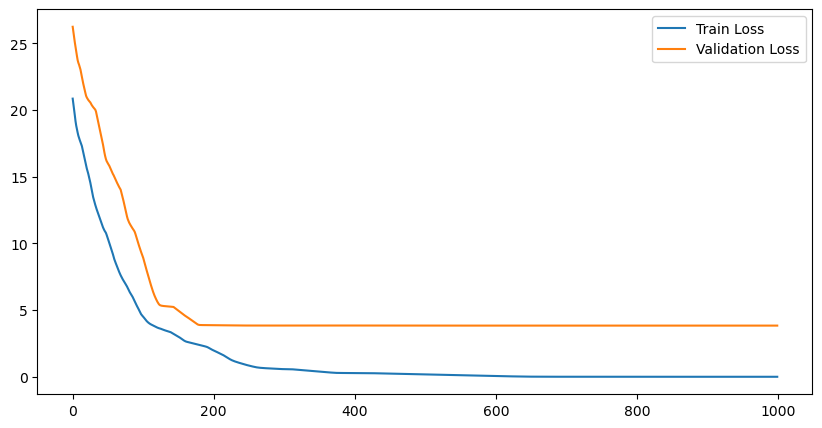

In [69]:
# Draw loss curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()


In [70]:
trained_model = NeuralNetwork(13, 100, 3)
trained_model.load('best_wine_model.npz')
# Test model
y_pred_test = trained_model.forward(X_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)
test_acc = np.mean(y_pred_classes == y_test)

from sklearn.metrics import classification_report, confusion_matrix

print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


TypeError: NeuralNetwork.__init__() takes 3 positional arguments but 4 were given

In [ ]:
# Tạo model mới và load weights đã lưu
model_continued = NeuralNetwork(13, 100, 3)
model_continued.load('last_wine_model.npz')

# Tiếp tục train với model đã load
print("\nTiếp tục training từ checkpoint...")
train_losses_cont, val_losses_cont = train_model(model_continued, 1000, 0.1)



Linear1 parameters: 1400
Linear2 parameters: 20200
Linear3 parameters: 20100
Linear4 parameters: 303
total parameters: 42003
Model loaded from last_wine_model.npz

Tiếp tục training từ checkpoint...
Epoch 1/1000, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 0.9630
Epoch 100/1000, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 0.9630
Epoch 200/1000, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 0.9630
Epoch 300/1000, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 0.9630
Epoch 400/1000, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 0.9630
Epoch 500/1000, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 0.9630
Epoch 600/1000, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 0.9630
Epoch 700/1000, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 0.9630
Epoch 800/1000, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 0.9630
Ep